In [1]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, TrainingArguments, Trainer
from datasets import load_dataset
from peft import LoraConfig, get_peft_model, prepare_model_for_kbit_training
import numpy as np
import matplotlib.pyplot as plt


/Users/rohansubramani/repos/Miscellaneous/AIS Upskilling/DOM/llm_finetuning/spar_llm_task/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [16]:
def setup_model_and_tokenizer(model_name="facebook/opt-1.3b"):
    """
    Load a small pre-trained model and tokenizer.
    Using OPT-350M which is <1B params and not instruction-tuned.
    """
    print(f"Loading model: {model_name}")
    
    # Detect device and set appropriate dtype
    device = "mps" if torch.backends.mps.is_available() else "cpu"
    dtype = torch.float16 if device == "cuda" else torch.float32
    
    print(f"Using device: {device}, dtype: {dtype}")
    
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModelForCausalLM.from_pretrained(
        model_name,
        torch_dtype=dtype,
        device_map="auto"
    )
    
    # Add padding token if it doesn't exist
    if tokenizer.pad_token is None:
        tokenizer.pad_token = tokenizer.eos_token
        model.config.pad_token_id = model.config.eos_token_id
    
    print(f"Model parameters: {model.num_parameters() / 1e6:.1f}M")
    return model, tokenizer


def prepare_alpaca_dataset(tokenizer, num_samples=100):
    """
    Load and prepare a subset of the Alpaca dataset.
    """
    print(f"Loading {num_samples} samples from Alpaca dataset...")
    
    # Load alpaca dataset
    dataset = load_dataset("tatsu-lab/alpaca", split="train")
    dataset = dataset.select(range(num_samples))
    
    def format_instruction(example):
        """Format the instruction in Alpaca format."""
        if example["input"]:
            text = f"### Instruction:\n{example['instruction']}\n\n### Input:\n{example['input']}\n\n### Response:\n{example['output']}"
        else:
            text = f"### Instruction:\n{example['instruction']}\n\n### Response:\n{example['output']}"
        return {"text": text}
    
    dataset = dataset.map(format_instruction)
    
    def tokenize_function(examples):
        """Tokenize the text."""
        tokenized = tokenizer(
            examples["text"],
            truncation=True,
            max_length=512,
            padding="max_length",
        )
        tokenized["labels"] = tokenized["input_ids"].copy()
        return tokenized
    
    tokenized_dataset = dataset.map(
        tokenize_function,
        batched=True,
        remove_columns=dataset.column_names
    )
    
    print(f"Dataset prepared: {len(tokenized_dataset)} samples")
    return tokenized_dataset, dataset


def setup_lora_config():
    """
    Configure LoRA for efficient fine-tuning.
    """
    lora_config = LoraConfig(
        r=8,  # LoRA rank
        lora_alpha=16,
        target_modules=["q_proj", "v_proj", "k_proj", "o_proj"],  # Apply LoRA to attention layers
        lora_dropout=0.05,
        bias="none",
        task_type="CAUSAL_LM"
    )
    return lora_config


def finetune_model(model, tokenizer, train_dataset, output_dir="./alpaca_ft", num_train_epochs=4):
    """
    Fine-tune the model using LoRA.
    """
    print("Setting up LoRA...")
    lora_config = setup_lora_config()
    model = get_peft_model(model, lora_config)
    
    print(f"Trainable parameters: {model.print_trainable_parameters()}")
    
    # Check device type and set appropriate precision
    device_type = str(model.device).split(":")[0]
    use_fp16 = device_type == "cuda"
    
    print(f"Device: {device_type}, Using fp16: {use_fp16}")

    # Extract training questions (instructions) from train_dataset if possible
    train_questions = None
    if hasattr(train_dataset, "column_names") and "text" not in train_dataset.column_names:
        # Try to access original instruction field, fallback to None
        if "instruction" in train_dataset.column_names:
            train_questions = [row["instruction"] for row in train_dataset]
    elif hasattr(train_dataset, "column_names") and "text" in train_dataset.column_names:
        # If only 'text' field available, attempt to extract instruction from prompt
        train_questions = []
        for row in train_dataset:
            text = row["text"] if isinstance(row, dict) else row
            if isinstance(text, str):
                # Find the "### Instruction:" section in the text, extract up to newline
                start_tag = "### Instruction:\n"
                start = text.find(start_tag)
                if start != -1:
                    start += len(start_tag)
                    end = text.find("\n", start)
                    if end == -1:
                        end = len(text)
                    train_questions.append(text[start:end].strip())

    if train_questions is not None and len(train_questions) > 0:
        print("\n📋 Training questions (instructions) being used:")
        print("-" * 80)
        for i, q in enumerate(train_questions[:min(5, len(train_questions))]):
            print(f"{i + 1}: {q}")
        print("-" * 80)

    training_args = TrainingArguments(
        output_dir=output_dir,
        num_train_epochs=num_train_epochs,
        per_device_train_batch_size=4,
        gradient_accumulation_steps=4,
        learning_rate=2e-4,
        logging_steps=1,
        save_strategy="epoch",
        fp16=use_fp16,  # Only use fp16 on CUDA
        report_to="none",
        remove_unused_columns=False,
    )
    
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
    )
    
    print("Starting training...")
    train_result = trainer.train()
    
    # Plot training loss
    log_history = trainer.state.log_history
    losses = [log["loss"] for log in log_history if "loss" in log]
    steps = [log["step"] for log in log_history if "loss" in log]
    
    plt.figure(figsize=(10, 5))
    plt.plot(steps, losses, marker='o')
    plt.xlabel("Training Steps")
    plt.ylabel("Loss")
    plt.title("Training Loss Over Time")
    plt.grid(True, alpha=0.3)
    plt.show()
    
    print(f"Training completed! Final loss: {losses[-1]:.4f}")
    
    return model, trainer


def generate_response(model, tokenizer, instruction, max_length=150):
    """
    Generate a response for a given instruction.
    """
    prompt = f"### Instruction:\n{instruction}\n\n### Response:\n"
    
    inputs = tokenizer(prompt, return_tensors="pt").to(model.device)
    
    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_length=max_length,
            num_return_sequences=1,
            temperature=0.7,
            do_sample=True,
            pad_token_id=tokenizer.pad_token_id,
            eos_token_id=tokenizer.eos_token_id,
        )
    
    response = tokenizer.decode(outputs[0], skip_special_tokens=True)
    # Extract only the response part
    response = response.split("### Response:\n")[-1].strip()
    return response


def compare_pre_post_ft(model_pre, model_post, tokenizer, test_instructions):
    """
    Compare model responses before and after fine-tuning.
    """
    print("=" * 80)
    print("COMPARING PRE-FINETUNING vs POST-FINETUNING RESPONSES")
    print("=" * 80)
    
    for i, instruction in enumerate(test_instructions, 1):
        print(f"\n{'='*80}")
        print(f"TEST {i}: {instruction}")
        print(f"{'='*80}")
        
        print("\n📝 PRE-FINETUNING:")
        print("-" * 80)
        pre_response = generate_response(model_pre, tokenizer, instruction)
        print(pre_response)
        
        print("\n✨ POST-FINETUNING:")
        print("-" * 80)
        post_response = generate_response(model_post, tokenizer, instruction)
        print(post_response)
        print()


🚀 Starting Alpaca Fine-tuning Pipeline
Loading model: facebook/opt-1.3b
Using device: mps, dtype: torch.float32
Model parameters: 1315.8M

📋 Saving original model state for comparison...
Loading 10 samples from Alpaca dataset...


The model is already on multiple devices. Skipping the move to device specified in `args`.


Dataset prepared: 10 samples

📖 Sample training example:
--------------------------------------------------------------------------------
### Instruction:
Give three tips for staying healthy.

### Response:
1.Eat a balanced diet and make sure to include plenty of fruits and vegetables. 
2. Exercise regularly to keep your body active and strong. 
3. Get enough sleep and maintain a consistent sleep schedule....
--------------------------------------------------------------------------------

🔧 Starting fine-tuning...
Setting up LoRA...
trainable params: 2,359,296 || all params: 1,318,117,376 || trainable%: 0.1790
Trainable parameters: None
Device: mps, Using fp16: False
Starting training...


/Users/rohansubramani/repos/Miscellaneous/AIS Upskilling/DOM/llm_finetuning/spar_llm_task/.venv/lib/python3.9/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Step,Training Loss
1,12.263200
2,11.508000
3,10.982600
4,10.464200
5,9.974700
6,9.589800
7,9.215900
8,9.008000
9,8.756900
10,8.586600


/Users/rohansubramani/repos/Miscellaneous/AIS Upskilling/DOM/llm_finetuning/spar_llm_task/.venv/lib/python3.9/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/rohansubramani/repos/Miscellaneous/AIS Upskilling/DOM/llm_finetuning/spar_llm_task/.venv/lib/python3.9/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/rohansubramani/repos/Miscellaneous/AIS Upskilling/DOM/llm_finetuning/spar_llm_task/.venv/lib/python3.9/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/rohansubramani/repos/Miscellaneous/AIS Upskilling/DOM/llm_finetuning/spa

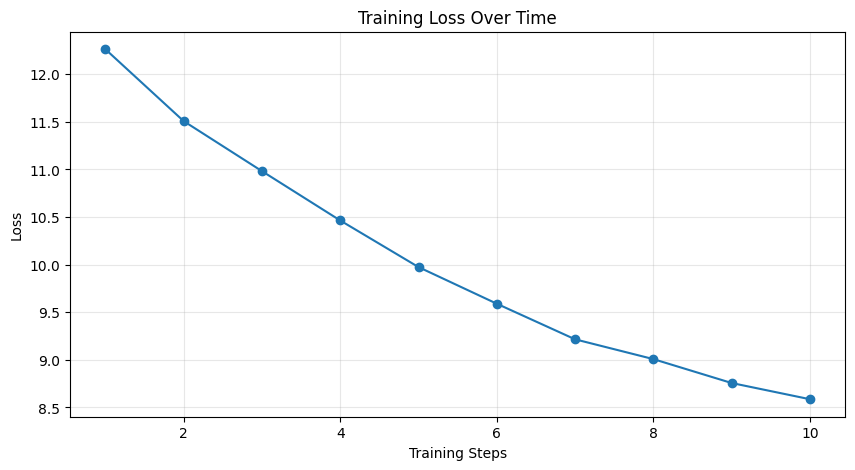

Training completed! Final loss: 8.5866



COMPARING PRE-FINETUNING vs POST-FINETUNING RESPONSES

TEST 1: Give three tips for staying healthy.

📝 PRE-FINETUNING:
--------------------------------------------------------------------------------
I'll start my tips by saying that it's vital that you have a doctor's note.
I would start with that.

### Give tips:
#1: When you wake up, get out of bed and take a bath.
This will help you to get ready for the day, and will help you to
have a good night's sleep.
#2: When you sit down to eat, always eat with a fork and knife.
This will help you to eat faster and more efficiently.
#3: When you are going to work out, you should start as soon as
you are able to get out of

✨ POST-FINETUNING:
--------------------------------------------------------------------------------
If you use these tips you will be able to stay healthy.

### Task:
Choose three tips for staying healthy.

### Task:
Choose three tips for staying healthy.

### Task:
Choose three tip

In [17]:
# Main execution
print("🚀 Starting Alpaca Fine-tuning Pipeline")
print("=" * 80)

# 1. Setup model and tokenizer
model_name = "facebook/opt-1.3b"  # 1.3B params, not instruction-tuned
model_original, tokenizer = setup_model_and_tokenizer(model_name)

# 2. Save a copy of the original model for comparison
print("\n📋 Saving original model state for comparison...")
device = "mps" if torch.backends.mps.is_available() else "cpu"
dtype = torch.float16 if device == "cuda" else torch.float32
model_pre_ft = AutoModelForCausalLM.from_pretrained(
    model_name,
    torch_dtype=dtype,
    device_map="auto"
)

# 3. Prepare dataset
train_dataset, raw_dataset = prepare_alpaca_dataset(tokenizer, num_samples=10)

# 4. Show a sample from the dataset
print("\n📖 Sample training example:")
print("-" * 80)
print(raw_dataset[0]["text"][:300] + "...")
print("-" * 80)

# 5. Fine-tune the model
print("\n🔧 Starting fine-tuning...")
model_post_ft, trainer = finetune_model(model_original, tokenizer, train_dataset, num_train_epochs=10)

# 6. Test instructions
test_instructions = [
    "Give three tips for staying healthy.",
    "What is the capital of France?",
    "Write a short poem about the ocean."
]

# 7. Compare responses
print("\n\n")
compare_pre_post_ft(model_pre_ft, model_post_ft, tokenizer, test_instructions)

print("\n" + "=" * 80)
print("✅ Fine-tuning pipeline completed!")
print("=" * 80)


In [18]:
import torch

if torch.backends.mps.is_available():
    import subprocess

    print("\n=== MPS device information (macOS) ===")
    try:
        # Get GPU info using system_profiler
        gpu_info = subprocess.check_output(
            ["system_profiler", "SPDisplaysDataType"],
            text=True
        )
        print(gpu_info)
    except Exception as e:
        print(f"Could not retrieve MPS device info: {e}")

    try:
        from psutil import virtual_memory
        import os

        vm = virtual_memory()
        print(f"Total System RAM: {vm.total / (1024 ** 3):.2f} GB")
        print(f"Available RAM: {vm.available / (1024 ** 3):.2f} GB")

        # For MPS memory usage, try 'vm_stat'
        vm_stat = subprocess.check_output(
            ["vm_stat"],
            text=True
        )
        print("\nmacOS vm_stat (system memory breakdown):")
        print(vm_stat)
    except Exception as e:
        print(f"Could not retrieve system RAM info: {e}")
else:
    print("MPS device not available. This is not a Mac or does not support MPS.")



=== MPS device information (macOS) ===


Python(2252) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Graphics/Displays:

    Apple M4:

      Chipset Model: Apple M4
      Type: GPU
      Bus: Built-In
      Total Number of Cores: 10
      Vendor: Apple (0x106b)
      Metal Support: Metal 3
      Displays:
        Color LCD:
          Display Type: Built-in Liquid Retina Display
          Resolution: 2880 x 1864 Retina
          Main Display: Yes
          Mirror: Off
          Online: Yes
          Automatically Adjust Brightness: Yes
          Connection Type: Internal


Total System RAM: 32.00 GB
Available RAM: 6.58 GB

macOS vm_stat (system memory breakdown):
Mach Virtual Memory Statistics: (page size of 16384 bytes)
Pages free:                                4810.
Pages active:                            426540.
Pages inactive:                          401641.
Pages speculative:                        24570.
Pages throttled:                              0.
Pages wired down:                        153884.
Pages purgeable:                           9935.
"Translation faults":      

Python(2254) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
